In [1]:
!pip install -q tensorflow keras-tuner pandas scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.5 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch


In [3]:

df = pd.read_csv('/content/sample_data/BTC_Data_final.csv')
df['Date'] = pd.to_datetime(df['Date'])

df['log_marketcap'] = np.log1p(df['marketcap'])
df['log_transactionvalue'] = np.log1p(df['transactionvalue'])
df['log_tweets'] = np.log1p(df['tweets'])
df['fee_to_reward_ratio'] = df['fee_to_reward'] / (df['mining_profitability'] + 1e-6)
df['priceUSD_t-1'] = df['priceUSD'].shift(1)
df.dropna(inplace=True)

X = df.drop(columns=['Date', 'priceUSD'])
y = df['priceUSD'].values.reshape(-1, 1)


In [4]:

n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train_raw, X_val_raw, X_test_raw = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train_raw, y_val_raw, y_test_raw = y[:train_end], y[train_end:val_end], y[val_end:]

scaler_X = MinMaxScaler().fit(X_train_raw)
scaler_y = MinMaxScaler().fit(y_train_raw)

X_train = scaler_X.transform(X_train_raw)
X_val = scaler_X.transform(X_val_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.transform(y_train_raw)
y_val = scaler_y.transform(y_val_raw)
y_test = scaler_y.transform(y_test_raw)

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [5]:

def build_model(hp):
    model = Sequential()

    # Lớp BiLSTM:
          # Bidirectional(...): chạy hai LSTM, một xuôi, một ngược → tăng khả năng học ngữ cảnh từ cả trước và sau.
          # hp.Int(...): cho phép tuner chọn số node (units) trong số {32, 64, 96, 128}.
          # activation='relu': hàm kích hoạt trong các node (tăng tính phi tuyến).
          # input_shape=(1, num_features): mỗi mẫu đầu vào có 1 bước thời gian và nhiều đặc trưng.
    model.add(Bidirectional(
        LSTM(units=hp.Int('units', 32, 128, step=32), activation='relu'),
        input_shape=(1, X_train.shape[1])
    ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
        ),
        loss='mse'
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='bilstm_tuner',
    project_name='btc_price'
)

tuner.search(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val),
             epochs=50, batch_size=32, callbacks=[EarlyStopping(patience=5)], verbose=1)

best_model = tuner.get_best_models(1)[0]


Trial 50 Complete [00h 00m 14s]
val_loss: 0.0016974785830825567

Best val_loss So Far: 0.00030018584220670164
Total elapsed time: 00h 20m 01s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test MAE: 457.78
Test RMSE: 682.70
Test R2: 0.9950
Test MSE: 466084.33
Test MAPE: 1.79%
    Actual     Predicted
0  43854.0  43108.589844
1  43922.0  44998.117188
2  44331.0  44612.414062
3  43185.0  44243.042969
4  42333.0  43609.785156
5  42336.0  42278.902344
6  42232.0  42691.277344
7  43867.0  43589.152344
8  43998.0  43927.941406
9  42666.0  43211.367188


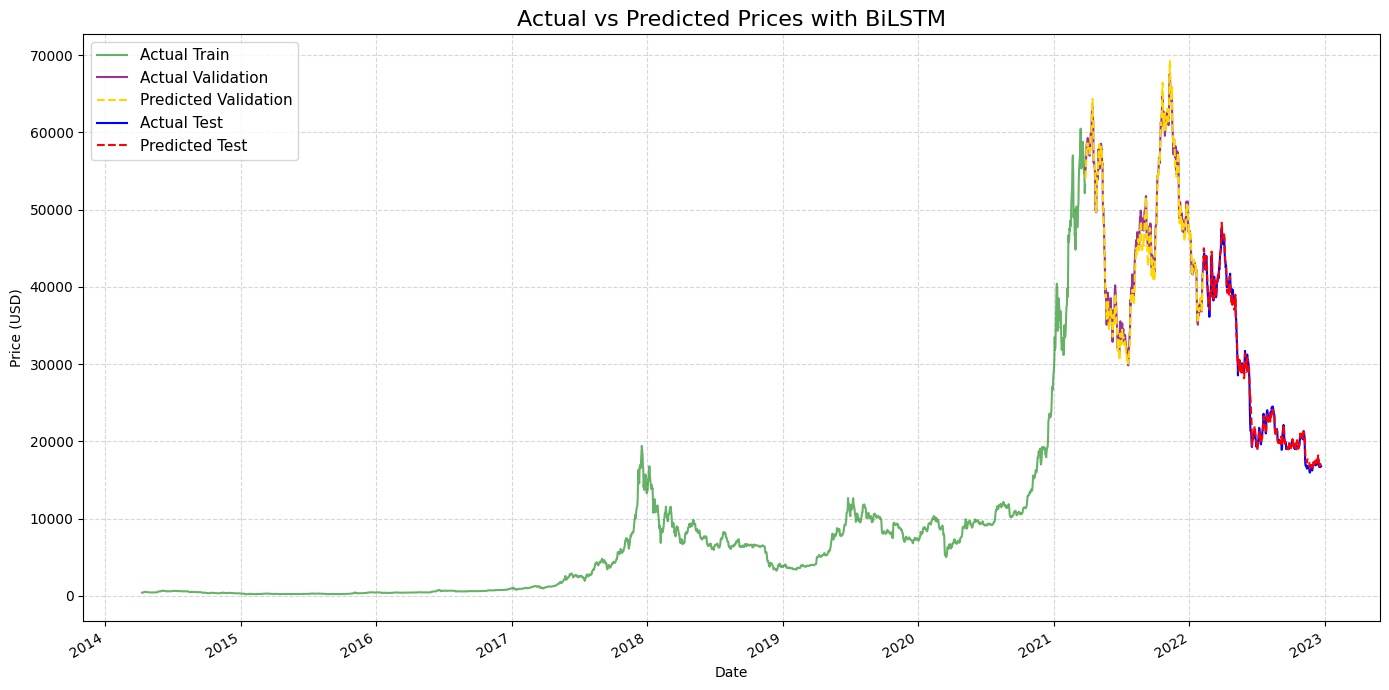

In [6]:

y_train_pred = best_model.predict(X_train_lstm)
y_val_pred = best_model.predict(X_val_lstm)
y_test_pred = best_model.predict(X_test_lstm)

y_train_true = scaler_y.inverse_transform(y_train)
y_val_true = scaler_y.inverse_transform(y_val)
y_test_true = scaler_y.inverse_transform(y_test)

y_train_pred_inv = scaler_y.inverse_transform(y_train_pred)
y_val_pred_inv = scaler_y.inverse_transform(y_val_pred)
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)

mae = mean_absolute_error(y_test_true, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred_inv))
r2 = r2_score(y_test_true, y_test_pred_inv)
mse = mean_squared_error(y_test_true, y_test_pred_inv)
mape = np.mean(np.abs((y_test_true - y_test_pred_inv) / y_test_true)) * 100

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2: {r2:.4f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test MAPE: {mape:.2f}%")

# Bảng kết quả
results = pd.DataFrame({
    'Actual': y_test_true.flatten(),
    'Predicted': y_test_pred_inv.flatten()
})
print(results.head(10))

train_dates = df['Date'].iloc[:train_end]
val_dates = df['Date'].iloc[train_end:val_end]
test_dates = df['Date'].iloc[val_end:]

plt.figure(figsize=(14, 7))
plt.plot(train_dates, y_train_true.flatten(), label='Actual Train', color='green', alpha=0.6)
plt.plot(val_dates, y_val_true.flatten(), label='Actual Validation', color='purple', alpha=0.8)
plt.plot(val_dates, y_val_pred_inv.flatten(), label='Predicted Validation', color='gold', linestyle='--')
plt.plot(test_dates, y_test_true.flatten(), label='Actual Test', color='blue')
plt.plot(test_dates, y_test_pred_inv.flatten(), label='Predicted Test', color='red', linestyle='--')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.title('Actual vs Predicted Prices with BiLSTM', fontsize=16)
plt.xlabel('Date'); plt.ylabel('Price (USD)')
plt.legend(fontsize=11); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


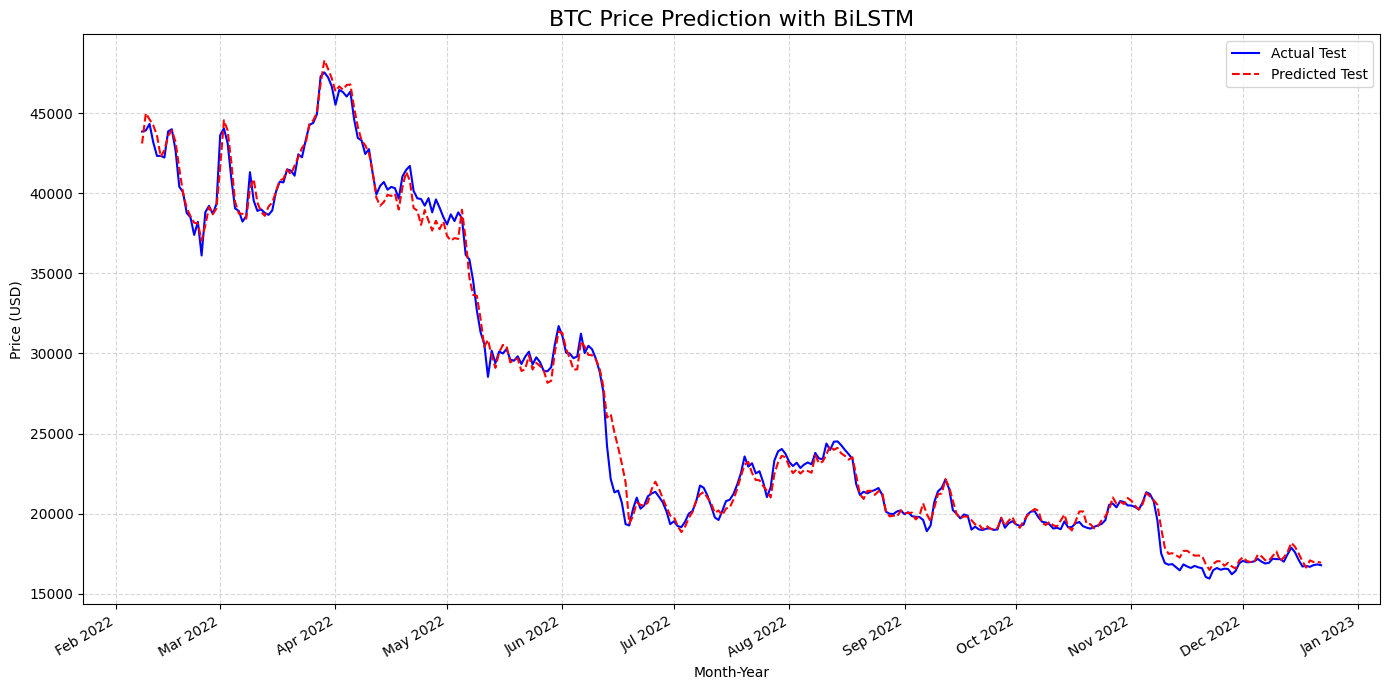

In [7]:
# Vẽ biểu đồ BTC Price Prediction with LSTM + Keras Tuner
test_dates = df['Date'].iloc[val_end:]
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_true.flatten(), label='Actual Test', color='blue')
plt.plot(test_dates, y_test_pred_inv.flatten(), label='Predicted Test', color='red', linestyle='--')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
plt.title('BTC Price Prediction with BiLSTM', fontsize=16)
plt.xlabel('Month-Year'); plt.ylabel('Price (USD)')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()